### Demo na konferencję EuroHPC (case z kodowaniem binarnym i z QAOA) - draft
DO ZMIANY: opis 
We will focus on the following workflow instance (for now, in the simplified problem, we will not use the Workflow or WorkflowSchedulingProblem classes, because we want to test the Unbalanced Penalization method https://arxiv.org/pdf/2211.13914.pdf), which is not included in QHyper. But I will leave it here just for reference (especially for observation of what data is in the time and cost matrices).

In [1]:
import sys
sys.path.append("..")
from QHyper.problems.workflow_scheduling import (
    Workflow,
    WorkflowSchedulingProblem,
)

tasks_file =  "workflows_data/workflows/3_tasks_3_machines_1_path.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 13

workflow = Workflow(tasks_file, machines_file, deadline)
wsp = WorkflowSchedulingProblem(workflow)


In [2]:
wsp.workflow.cost_matrix


,MachineA,MachineB,MachineC
task1,6.0,8.0,8.0
task2,3.0,4.0,4.0
task3,12.0,16.0,16.0


Uwaga: tutaj tak naprawdę jest dodana jeszcze jedna maszyna (liczba maszyn musi być 2^n)

In [3]:
wsp.workflow.time_matrix


,MachineA,MachineB,MachineC
task1,6.0,2.0,4.0
task2,3.0,1.0,2.0
task3,12.0,4.0,8.0


Below is the list of the hyperparameters (weights) that can be changed.  I assumed that the weights hyper_b, hyper_c, hyper_d can be the same, since the constraint they represent has a very similar form.

In [4]:
hyper_params = {'cost_function_weight': 1, # weight for: cost function
               'deadline_linear_form_weight': -2, # weight for: deadline constraint - linear form (-- this is from the unbalanced penalization approach)
                'deadline_quadratic_form_weight': 2} # weight for: deadline constraint - quadratic form


 DO ZMIANY: generacja tych wzorów z WFCommons

In [5]:
import numpy as np
import sympy
from sympy.core.expr import Expr

from QHyper.problems.base import Problem
from QHyper.util import Expression


class SimpleWorkflowProblem(Problem):


    def __init__(self) -> None:
        #uwaga: to jest na sztywno
        num_of_qubits = 6 #wsp.workflow.cost_matrix.shape[0] * wsp.workflow.cost_matrix.shape[1]
        self.variables = sympy.symbols(' '.join([f'x{i}' for i in range(num_of_qubits)]))
        self._set_objective_function()
        self._set_constraints()

    def _set_objective_function(self) -> None:

        C_f = (6.0*(1-self.variables[0])*(1-self.variables[1])
        + 8.0*(1-self.variables[0])*(self.variables[1])
        + 8.0*(self.variables[0])*(1-self.variables[1])
        + 2.0*(self.variables[0])*(self.variables[1])
        + 3.0*(1-self.variables[2])*(1-self.variables[3])
        + 4.0*(1-self.variables[2])*(self.variables[3])
        + 4.0*(self.variables[2])*(1-self.variables[3])
        + 1.0*(self.variables[2])*(self.variables[3])
        + 12.0*(1-self.variables[4])*(1-self.variables[5])
        + 16.0*(1-self.variables[4])*(self.variables[5])
        + 16.0*(self.variables[4])*(1-self.variables[5])
        + 4.0*(self.variables[4])*(self.variables[5])  )

        self.deadline_aux=(6.0*(1-self.variables[0])*(1-self.variables[1])
       + 2.0*(1-self.variables[0])*(self.variables[1])
        + 4.0*(self.variables[0])*(1-self.variables[1])
        + 16.0*(self.variables[0])*(self.variables[1])
        + 3.0*(1-self.variables[2])*(1-self.variables[3])
        + 1.0*(1-self.variables[2])*(self.variables[3])
        + 2.0*(self.variables[2])*(1-self.variables[3])
        + 8.0*(self.variables[2])*(self.variables[3])
        + 12.0*(1-self.variables[4])*(1-self.variables[5])
        + 4.0*(1-self.variables[4])*(self.variables[5])
        + 8.0*(self.variables[4])*(1-self.variables[5])
        + 32.0*(self.variables[4])*(self.variables[5])  )

        K_f4_linear = deadline - self.deadline_aux
        K_f4_squared=K_f4_linear**2
        K_f4_squared1=sympy.expand(K_f4_squared)

       # print(K_f4_squared1, "\n\n")

        for i in range(6):
            K_f4_squared1=K_f4_squared1.subs(self.variables[i]**2, self.variables[i])
        #print(K_f4_squared1,"\n\n")

       # print(K_f4_squared1)
        self.objective_function = (Expression(hyper_params['cost_function_weight'] * C_f
                                              + hyper_params['deadline_linear_form_weight'] *  K_f4_linear
                                   + hyper_params['deadline_quadratic_form_weight'] * K_f4_linear**2))

    def _set_constraints(self):
       # print(self.deadline_aux)




        self.constraints = []

    def get_score(self, result, penalty=0):

        x = [int(val) for val in result]

        if (6.0*(1.0-x[0])*(1-x[1])
        + 2.0*(1.0-x[0])*(x[1])
        + 4.0*(x[0])*(1.0-x[1])
        + 16.0*(x[0])*(x[1])
        + 3.0*(1.0-x[2])*(1.0-x[3])
        + 1.0*(1.0-x[2])*(x[3])
        + 2.0*(x[2])*(1.0-x[3])
        + 8.0*(x[2])*(x[3])
        + 12.0*(1.0-x[4])*(1.0-x[5])
        + 4.0*(1.0-x[4])*(x[5])
        + 8.0*(x[4])*(1.0-x[5])
        + 32.0*(x[4])*(x[5]) <=13 ):

            return (6.0*(1.0-x[0])*(1.0-x[1])
        + 8.0*(1.0-x[0])*(x[1])
        + 8.0*(x[0])*(1.0-x[1])
        + 2.0*(x[0])*(x[1])
        + 3.0*(1.0-x[2])*(1.0-x[3])
        + 4.0*(1.0-x[2])*(x[3])
        + 4.0*(x[2])*(1.0-x[3])
        + 1.0*(x[2])*(x[3])
        + 12.0*(1.0-x[4])*(1.0-x[5])
        + 16.0*(1.0-x[4])*(x[5])
        + 16.0*(x[4])*(1.0-x[5])
        + 4.0*(x[4])*(x[5]) )

        return penalty


In [6]:
problem = SimpleWorkflowProblem()


In [7]:
print(f"Variables used to describe objective function"
      f" and constraints: {problem.variables}")
print(f"Objective function: {problem.objective_function}")
print("Constraints (RHS == 0):")
for constraint in problem.constraints:
    print(f"    {constraint}")


Variables used to describe objective function and constraints: (x0, x1, x2, x3, x4, x5)
Objective function: {('x0', 'x0', 'x1', 'x1'): 512.0, ('x0', 'x0', 'x1'): -128.0, ('x0', 'x0'): 8.0, ('x0', 'x1', 'x1'): -256.0, ('x0', 'x1', 'x2', 'x3'): 512.0, ('x0', 'x1', 'x2'): -64.0, ('x0', 'x1', 'x3'): -128.0, ('x0', 'x1', 'x4', 'x5'): 2048.0, ('x0', 'x1', 'x4'): -256.0, ('x0', 'x1', 'x5'): -512.0, ('x0', 'x1'): 568.0, ('x0', 'x2', 'x3'): -64.0, ('x0', 'x2'): 8.0, ('x0', 'x3'): 16.0, ('x0', 'x4', 'x5'): -256.0, ('x0', 'x4'): 32.0, ('x0', 'x5'): 64.0, ('x0',): -66.0, ('x1', 'x1'): 32.0, ('x1', 'x2', 'x3'): -128.0, ('x1', 'x2'): 16.0, ('x1', 'x3'): 32.0, ('x1', 'x4', 'x5'): -512.0, ('x1', 'x4'): 64.0, ('x1', 'x5'): 128.0, ('x1',): -134.0, ('x2', 'x2', 'x3', 'x3'): 128.0, ('x2', 'x2', 'x3'): -32.0, ('x2', 'x2'): 2.0, ('x2', 'x3', 'x3'): -64.0, ('x2', 'x3', 'x4', 'x5'): 1024.0, ('x2', 'x3', 'x4'): -128.0, ('x2', 'x3', 'x5'): -256.0, ('x2', 'x3'): 276.0, ('x2', 'x4', 'x5'): -128.0, ('x2', 'x4'): 1

# 3 Using QHyper

Do zmiany - konfiguracja wag

In [8]:
params_config = {
       'angles': [[0.1e-13]*6, [np.pi/2]*6], # QAOA angles - first we have gammas (for the cost Hamiltonian), then we have betas (for the mixer)
    #'angles': [[3.23810485e-04,  3.89068182e-04,  4.08362541e-04,  2.18136406e-04,
   #3.91692476e-04,  3.01205096e-04],
 #[-2.51645530e+02, -1.22816763e+02, -1.20555243e+02, -9.45352537e+01,
  #-9.88528753e+01, -8.19648493e+01]] , 
    'hyper_args': [1, # do not change - this should be the weight for the 'cost function' but since in our cost function
                          # we also have the deadline in the linear form (as of now it needs to be implemented this way due to QHyper limitations)
                          # the weight for the actual cost function is set there. THIS WILL NOT WORK WELL WITH HYPER-QAOA.

                       ],
    }


In [9]:
# Create a VQA instance with QAOA as PQC and scipy optimizer
# This can be done in two various way
# 1. Providing dict with config (usefull to save experiment confing in e.g JSON)
# DO ZMIANY sqaoa -> qaoa (backend= "default.qubit") oraz QNG optimiser (krok 0.0001) 50 krokow
from QHyper.solvers import VQA

solver_config = {
    "pqc": {
        "type": "qml_qaoa",
        "layers": 6,
        "optimizer": "qng",
        "optimizer_args": {
            "stepsize": 0.0001,
            "steps": 10,
            "verbose": True,
        },
        "backend": "default.qubit",
    },
    "params_inits": params_config
}
vqa = VQA.from_config(problem, config=solver_config)


In [10]:
solver_results = vqa.solve()


Step 1/10: 612.9999999999897
Step 2/10: 612.9999999919736
Step 3/10: 500.2934557003054
Step 4/10: 208.1912732111584
Step 5/10: 177.73599343318492
Step 6/10: 171.38603295243513
Step 7/10: 166.1401849860502
Step 8/10: 159.34381784367747
Step 9/10: 151.1541278057249
Step 10/10: 143.0212591340686
[[ 1.51545611e-04  3.63911997e-04  2.17403290e-04  2.04811744e-05
   9.70601370e-05  2.38966920e-04]
 [-2.51599129e+02 -1.22776394e+02 -1.20593112e+02 -9.45923852e+01
  -9.88407243e+01 -8.19850018e+01]]
[0.01362292 0.02282725 0.02379919 0.00060116 0.0178262  0.02630792
 0.02764738 0.00066213 0.01795055 0.02604592 0.02680608 0.00035973
 0.01236879 0.01927429 0.01760619 0.00029858 0.02132406 0.02789721
 0.02924239 0.00078146 0.02657823 0.03063626 0.03228726 0.00089931
 0.02654277 0.03007983 0.03107852 0.00051815 0.01830386 0.02245455
 0.02066167 0.00021463 0.02161668 0.02748242 0.027739   0.00021348
 0.02684014 0.02995823 0.03046919 0.00029593 0.02647243 0.02910866
 0.02900426 0.00013348 0.01721674 

In [18]:
print(f"Best params: {solver_results.params}")


Best params: {'angles': tensor([[ 3.23810485e-04,  3.89068182e-04,  4.08362541e-04,
          2.18136406e-04,  3.91692476e-04,  3.01205096e-04],
        [-2.51645530e+02, -1.22816763e+02, -1.20555243e+02,
         -9.45352537e+01, -9.88528753e+01, -8.19648493e+01]], requires_grad=True), 'hyper_args': tensor([1], requires_grad=True)}


In [19]:
from QHyper.util import (
    weighted_avg_evaluation, sort_solver_results, add_evaluation_to_results)

# Evaluate results with weighted average evaluation
print("Evaluation:")
print(weighted_avg_evaluation(
    solver_results.results_probabilities, problem.get_score,
    penalty=0, limit_results=64, normalize=True
))
print("Sort results:")
sorted_results = sort_solver_results(
    solver_results.results_probabilities, limit_results=64)

# Add evaluation to results
results_with_evaluation = add_evaluation_to_results(
    sorted_results, problem.get_score, penalty=0)

for result, (probability, evaluation) in results_with_evaluation.items():
    print(f"Result: {result}, "
          f"Prob: {probability:.5}, "
          f"Evaluation: {evaluation}")


Evaluation:
13.401237505464907
Sort results:
Result: 010110, Prob: 0.045815, Evaluation: 28.0
Result: 010101, Prob: 0.044811, Evaluation: 28.0
Result: 011001, Prob: 0.04398, Evaluation: 28.0
Result: 011010, Prob: 0.043734, Evaluation: 28.0
Result: 100101, Prob: 0.04348, Evaluation: 28.0
Result: 100110, Prob: 0.042411, Evaluation: 28.0
Result: 101001, Prob: 0.042035, Evaluation: 28.0
Result: 101010, Prob: 0.03978, Evaluation: 0
Result: 010010, Prob: 0.038648, Evaluation: 27.0
Result: 100010, Prob: 0.037264, Evaluation: 0
Result: 100001, Prob: 0.036147, Evaluation: 27.0
Result: 010001, Prob: 0.035911, Evaluation: 27.0
Result: 000110, Prob: 0.031156, Evaluation: 0
Result: 001010, Prob: 0.03105, Evaluation: 0
Result: 011101, Prob: 0.030247, Evaluation: 0
Result: 101101, Prob: 0.028066, Evaluation: 0
Result: 001001, Prob: 0.027694, Evaluation: 26.0
Result: 011110, Prob: 0.02741, Evaluation: 0
Result: 000101, Prob: 0.027082, Evaluation: 26.0
Result: 101110, Prob: 0.024064, Evaluation: 0
Resu

<Axes: xlabel='index', ylabel='value'>

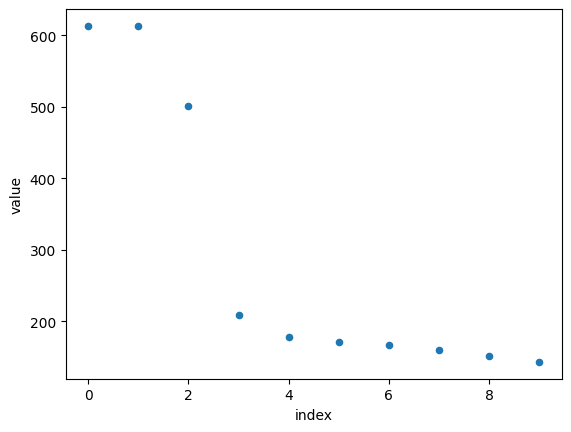

In [13]:
import pandas as pd

pd.DataFrame(solver_results.history[0]).reset_index().plot(x='index',y='value', kind='scatter')


In [20]:
from QHyper.solvers import VQA
tester_config = {
    'pqc': {
        'type': 'wfqaoa',
        'layers': 6,
    }
}

tester = VQA.from_config(problem, config=tester_config)

In [15]:
bp={'angles': ([[ 3.23810485e-04,  3.89068182e-04,  4.08362541e-04,
          2.18136406e-04,  3.91692476e-04,  3.01205096e-04],
        [-2.51645530e+02, -1.22816763e+02, -1.20555243e+02,
         -9.45352537e+01, -9.88528753e+01, -8.19648493e+01]]), 'hyper_args': [1]}
#bp={'angles':([[0.1e-13]*6, [np.pi/2]*6]), 'hyper_args': [1]}

In [16]:
solver_results=tester.solve(bp)

[[ 3.23810485e-04  3.89068182e-04  4.08362541e-04  2.18136406e-04
   3.91692476e-04  3.01205096e-04]
 [-2.51645530e+02 -1.22816763e+02 -1.20555243e+02 -9.45352537e+01
  -9.88528753e+01 -8.19648493e+01]]
[7.16616139e-04 1.65026622e-02 2.02396594e-02 9.75745992e-05
 2.04137350e-03 2.70820123e-02 3.11562658e-02 1.15866309e-04
 2.34652941e-03 2.76943181e-02 3.10495202e-02 1.35582111e-04
 9.59928472e-04 1.74465300e-02 1.78238224e-02 1.01846133e-04
 6.08495685e-03 3.59113776e-02 3.86476428e-02 6.20585198e-05
 1.54580605e-02 4.48107079e-02 4.58149497e-02 5.33037023e-05
 1.66982433e-02 4.39798692e-02 4.37336067e-02 4.27677439e-05
 8.62920985e-03 3.02467906e-02 2.74098227e-02 5.82827667e-05
 7.62238652e-03 3.61468669e-02 3.72638489e-02 1.17363540e-04
 1.80378358e-02 4.34797494e-02 4.24109178e-02 1.31573914e-04
 1.90989041e-02 4.20354637e-02 3.97796734e-02 2.09062949e-04
 9.49391732e-03 2.80660534e-02 2.40637082e-02 1.21043416e-04
 1.22752830e-03 1.23704718e-02 9.85676422e-03 1.92038736e-05
 3.5

In [17]:
#print(solver_results.history[0])